### CNN using data augmentation
##### Overfitting occurs when a model learns the training data too well and struggles to generalize to new, unseen data, often due to an insufficient number of training samples. Data augmentation addresses this by creating more training examples from the existing ones through random, realistic-looking image transformations. This ensures the model sees slightly different versions of the same image during each training epoch, exposing it to a wider range of data variations and improving its ability to generalize. In Keras, data augmentation can be implemented by adding dedicated layers at the beginning of the model.
##### In Keras, this can be done by adding a number of data augmentation layers at the start of your model. 

In [12]:
import keras
from keras import layers
from keras.utils import image_dataset_from_directory
import os, shutil, pathlib

original_dir = pathlib.Path("cats-dogs-images")
new_base_dir = pathlib.Path("cats_vs_dogs_subset")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images that go through it
    layers.RandomRotation(0.2), # Rotates the input images by a random value in the range [–10%, +10%] | [–36 degrees, +36 degrees]
    layers.RandomZoom(0.2) # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


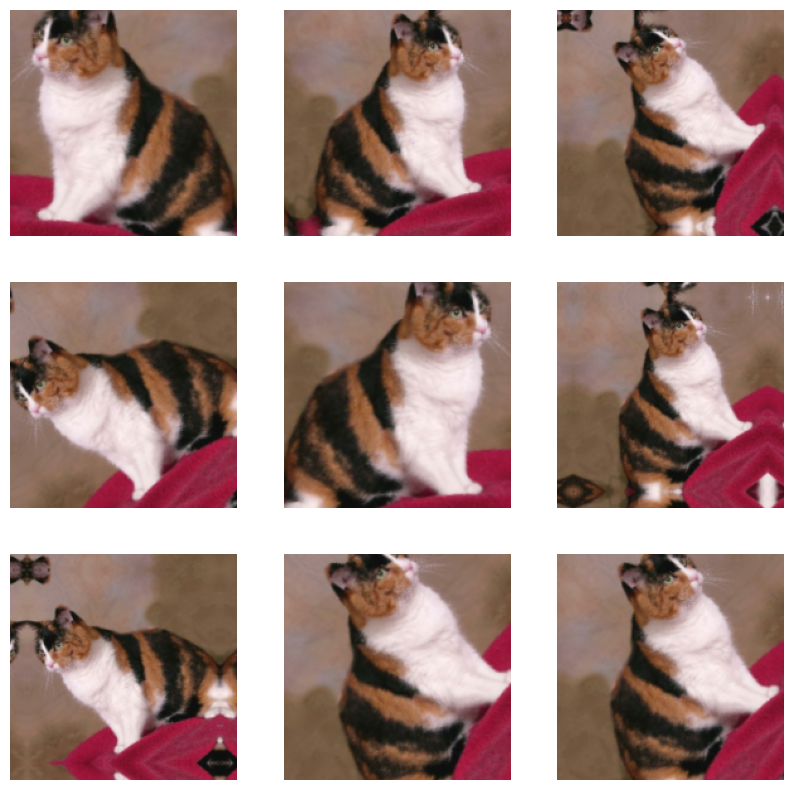

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

for images, _ in train_dataset.take(1): # take 1 batch from train_dataset
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))   
        plt.axis("off")

##### Training a model with data augmentation means it will never see the exact same input twice. However, since these augmented images are derived from a limited set of original images, they remain highly correlated, and data augmentation alone might not fully eliminate overfitting. To further mitigate this, a Dropout layer will be added before the final dense classifier. It's important to note that, similar to Dropout, these random image augmentation layers are inactive during inference (when using predict() or evaluate()), so the model behaves as if these layers weren't present during evaluation.

In [14]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

<ul>
  <li>
    <strong>Training Data:</strong> This is the data the model uses to learn the underlying patterns and adjust its weights. The optimizer iterates through batches of this data, calculates the loss, and updates the model's parameters to minimize that loss.
  </li>
  <li>
    <strong>Validation Data:</strong> This data is held separate from the training data. It's used to evaluate the model's performance on unseen data during the training process. This allows you to:
    <ul>
      <li>
        <strong>Monitor for Overfitting:</strong> If the model performs well on the training data but poorly on the validation data, it's a sign that the model is memorizing the training data rather than learning generalizable features.
      </li>
      <li>
        <strong>Tune Hyperparameters:</strong> You can use the validation performance to make decisions about hyperparameters like the learning rate, number of epochs, or model architecture.
      </li>
      <li>
        <strong>Early Stopping:</strong> You can stop training early if the validation loss stops improving or starts to increase, preventing overfitting and saving training time.
      </li>
    </ul>
  </li>
</ul>

In [17]:
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath="convnet_from_scratch_with_augmentation.keras",
    save_best_only=True,
    monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.4897 - loss: 0.7003 - val_accuracy: 0.4990 - val_loss: 0.6928
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 504ms/step - accuracy: 0.5133 - loss: 0.6937 - val_accuracy: 0.5040 - val_loss: 0.6910
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - accuracy: 0.5406 - loss: 0.6914 - val_accuracy: 0.5410 - val_loss: 0.6823
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 484ms/step - accuracy: 0.6080 - loss: 0.6787 - val_accuracy: 0.5010 - val_loss: 0.7693
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 486ms/step - accuracy: 0.6156 - loss: 0.6666 - val_accuracy: 0.6140 - val_loss: 0.6509
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 517ms/step - accuracy: 0.6286 - loss: 0.6476 - val_accuracy: 0.6380 - val_loss: 0.6443
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - accuracy: 0.6671 - loss: 0.6385 - val_accuracy: 0.6000 - val_loss: 0.6516
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 488ms/step - accuracy: 0.6452 - loss: 0.6345 - 

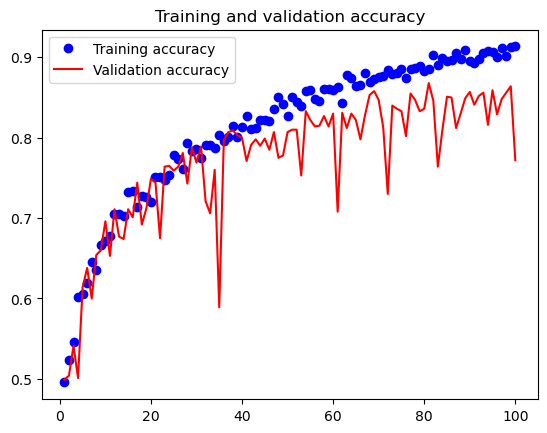

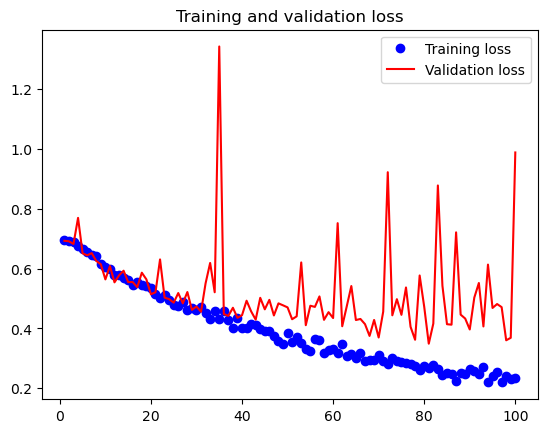

In [26]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, color="r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [24]:
test_model = keras.models.load_model("convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8803 - loss: 0.3767
Test accuracy: 0.863


##### Because of data augmentation and dropout, we start overfitting much later, around epochs 60–70 (compared to epoch 10 for the original model). The validation accuracy ends up consistently in the 80–85% range.
##### We get a test accuracy of 88%.
##### By further tuning the model’s configuration (such as the number of filters perconvolution layer, or the number of layers in the model), we might be able to get aneven better accuracy, likely up to 90%. But it would prove difficult to go any higher just by training our own convnet from scratch, because we have so little data to work with. As a next step to improve our accuracy on this problem, we’ll have to use a pre trained model,